In [2]:
import itertools
from pomps.policy_scope import PolicyComponent, MixedPolicyScope
from pomis.scm import *
import networkx as nx
from pomps.contextual_graphs import *
from pomps.policy_scope import *
from pomps.gp_fcm import *
from pomps.controllers import *
import pyro
import torch
from tqdm.auto import tqdm
import pyro.distributions as dist
from pomps.fcm import *

# from pomis.optimiser import CausalOptimiser, Objective, SCM
from pomis.scm import BoolDomain, SCM

In [3]:
def sampler_over():
    u1 = pyro.sample("U1", dist.Uniform(-1, 1))
    u2 = pyro.sample("U2", dist.Uniform(-1, 1))
    return {"U1": u1, "U2": u2}
fcm = FunctionalCausalModel({Functor(lambda U1: pyro.sample("C", dist.Normal(U1, 0.1)), 'C'),
                             Functor(lambda C, U1: pyro.sample("X1", dist.Normal(U1+C, 0.1)), 'X1'),
                             Functor(lambda C, X1, U2: pyro.sample("X2", dist.Normal(C+X1, torch.abs(U2))), 'X2'),
                             Functor(lambda U2, X2, C: pyro.sample("X2", 
                                        dist.Normal(torch.cos(C-X2)+U2/100, 0.01)), "Y")}, sampler_over)

# def model(count):
#     with pyro.plate("samples", count):
#         age = pyro.sample("age", dist.Uniform(55, 76))
#         bmi = pyro.sample("bmi", dist.Normal(27, 0.7))

#         aspirin_p = torch.sigmoid(-8.0 + 0.10 * age + 0.03 * bmi)
#         statin_p = torch.sigmoid(-13.0 + 0.10 * age + 0.20 * bmi)

#         aspirin = pyro.sample("aspirin", dist.Bernoulli(aspirin_p))
#         statin = pyro.sample("statin", dist.Bernoulli(statin_p))

#         cancer_p = torch.sigmoid(2.2 - 0.05 * age + 0.01 * bmi - 0.04 * statin + 0.02 * aspirin)
#         cancer = pyro.sample("cancer", dist.Bernoulli(cancer_p))

#         mean = 6.8 + 0.04 * age - 0.15 * bmi - 0.60 * statin + 0.55 * aspirin + 1.00 * cancer
#         y = pyro.sample("y", dist.Normal(mean, 0.4))
#     return y
# scm = SCM(model, [BoolDomain('aspirin'), BoolDomain('statin')], non_man={'age', 'bmi', 'cancer'})
# aspirin_graph = scm.induced_graph()
# ccg = ContextualCausalGraph(edges=aspirin_graph, interventional_variables={"aspirin", "statin"}, 
#                       contextual_variables={"age", "bmi"}, target='y')
# ccg = MPSDAGController.simplify(ccg)

In [4]:
aspirin_graph = fcm.induced_graph()
ccg = ContextualCausalGraph(edges=aspirin_graph, interventional_variables={"X1", "X2"}, 
                      contextual_variables={"C", "X1"}, target='Y')
ccg = MPSDAGController.simplify(ccg)
space = [RealDomain("X1", -5, 5), RealDomain("X2", -5, 5), RealDomain("C", -5, 5)]
gpf = GPFunctorFactory(space)

In [5]:
ccg.interventional_variables, ccg.contextual_variables, ccg.uc_variables

({'X1', 'X2'}, {'C', 'X1'}, {'U1', 'U2'})

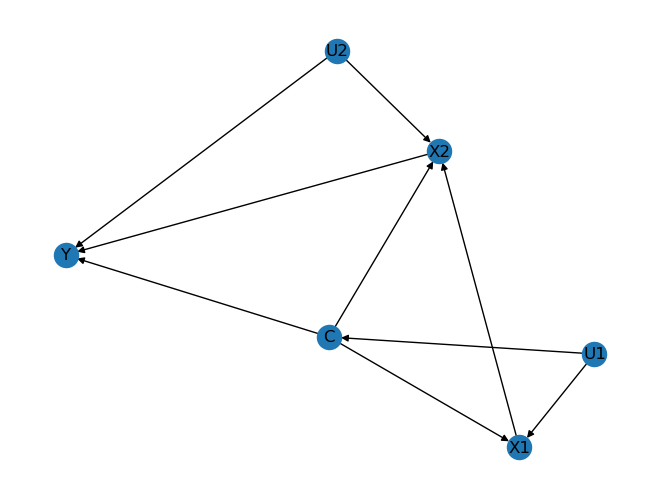

In [6]:
nx.draw(ccg, with_labels=True)

In [7]:
interventional_set = ccg.interventional_variables
contextual_set = ccg.contextual_variables

In [8]:
def all_combs(base, start=0):
    return list(itertools.chain(*[itertools.combinations(base, i) for i in range(start, len(base)+1)]))

def inter_cont_pair_gen(interventional_set, contextual_set):
    inter_segment = []
    context_space = all_combs(contextual_set)
    for inter in interventional_set:
        inter_segment += [[(inter, i) for i in context_space]]
    
    iam = all_combs(inter_segment)
    return itertools.chain(*[(itertools.product(*iam[i])) for i in range(len(iam))], [])

def mpss(pair_gen):
    for mps_row in pair_gen:
        yield MixedPolicyScope({PolicyComponent(target, set(context))  for target, context in mps_row })

In [9]:
a = {1}
b = a
b = b | {2}

In [10]:
a, b

({1}, {1, 2})

In [11]:
mpses = list(mpss(inter_cont_pair_gen(interventional_set, contextual_set)))
print(len(mpses))
graph_under_mps = [(MPSDAGController.graph_under_mps(mps, ccg), mps) for mps in mpses]
print(len(graph_under_mps))

graph_under_mps = [(g[0][0], g[1]) for g in graph_under_mps if g[0][1]]
print(len(graph_under_mps))

graph_under_mps = [g for g in graph_under_mps if MPSReductor.action_relevance_check(g[1], g[0]) and MPSReductor.context_relevance_check(g[1], g[0])]
print(len(graph_under_mps))
graph_under_mps = [g for g in graph_under_mps if not MPSReductor.sufficiently_not_pomp(g[1], g[0])]
print(len(graph_under_mps))

25
25
15
set()
call
set()
call
{'X1'}
call
{'C'}
call
set()
call
set()
call
{'X1'} set()
{'X2', 'X1'} {'X1'}
{'X2', 'X1'} {'X1'}
{'X2', 'X1'} {'X2', 'X1'}
{'X2', 'X1'} {'X2', 'X1'}
set()
call
set()
call
{'X1'}
call
{'X1'} {'X1'}
{'C'}
call
{'C', 'X1'} {'C'}
{'X2', 'C', 'X1'} {'C', 'X1'}
{'X2', 'C', 'X1'} {'C', 'X1'}
{'X2', 'C', 'X1'} {'X2', 'C', 'X1'}
{'X2', 'C', 'X1'} {'X2', 'C', 'X1'}
{'X1'}
call
{'C'}
call
{'C', 'X1'} {'C'}
{'X2', 'C', 'X1'} {'C', 'X1'}
{'X2', 'C', 'X1'} {'C', 'X1'}
{'X2', 'C', 'X1'} {'X2', 'C', 'X1'}
{'X2', 'C', 'X1'} {'X2', 'C', 'X1'}
7
set()
call
{'X2'} set()
{'X2'} {'X2'}
{'C'}
call
{'X2', 'C'} {'C'}
{'X2', 'C'} {'X2', 'C'}
{'X1'}
call
{'X2', 'X1'} {'X1'}
{'X2', 'X1'} {'X2', 'X1'}
set()
call
{'X1'} set()
{'X1'} {'X1'}
{'X1'}
call
{'X2', 'X1'} {'X1'}
{'X2', 'X1'} {'X2', 'X1'}
3


In [12]:
graph_under_mps

[(<pomps.contextual_graphs.ContextualCausalGraph at 0x1e4e2a44730>, ),
 (<pomps.contextual_graphs.ContextualCausalGraph at 0x1e4e2a09d60>,
  <X2, {'C'}>),
 (<pomps.contextual_graphs.ContextualCausalGraph at 0x1e4e2b88910>,
  <X1, {'C'}>)]

In [13]:
graph, mps = graph_under_mps[-1]
mps

<X1, {'C'}>

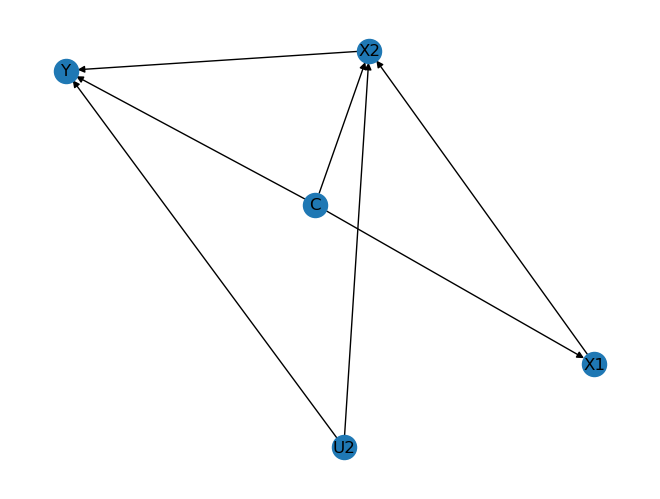

In [14]:
nx.draw(graph, with_labels=True)

In [15]:
policy = PolicyFCM.mps_to_gp_policy(mps, gpf)

In [16]:
fcm_m = PolicyFCM.fcm_with_policy(fcm, policy)

In [17]:
for i in tqdm(range(80)):
    smp = fcm_m.sample()
    y = smp[graph.target]
    y = torch.tensor([y])
    for p in policy:
        p.functional.observe(-y)
    print(smp)

  0%|          | 0/80 [00:00<?, ?it/s]

{'C': tensor(-0.7487), 'X1': tensor(-5.), 'X2': tensor(-5.3289), 'Y': tensor(-0.1195)}
{'C': tensor(0.8652), 'X1': tensor(0.), 'X2': tensor(-1.4558), 'Y': tensor(-0.6691)}
{'C': tensor(-0.9276), 'X1': tensor(2.5000), 'X2': tensor(0.6573), 'Y': tensor(-0.0050)}
{'C': tensor(0.3047), 'X1': tensor(1.2130), 'X2': tensor(1.6239), 'Y': tensor(0.2580)}
{'C': tensor(0.7998), 'X1': tensor(-2.4489), 'X2': tensor(-0.9687), 'Y': tensor(-0.1813)}
{'C': tensor(-0.4782), 'X1': tensor(-4.5391), 'X2': tensor(-4.0898), 'Y': tensor(-0.8770)}
{'C': tensor(-0.6484), 'X1': tensor(1.2131), 'X2': tensor(1.1154), 'Y': tensor(-0.1825)}
{'C': tensor(-0.2777), 'X1': tensor(1.1846), 'X2': tensor(0.8142), 'Y': tensor(0.4524)}
{'C': tensor(-0.4530), 'X1': tensor(1.1658), 'X2': tensor(1.0981), 'Y': tensor(0.0035)}
{'C': tensor(-0.0687), 'X1': tensor(1.1848), 'X2': tensor(1.8359), 'Y': tensor(-0.3358)}
Warning - optimization restart 7/10 failed
{'C': tensor(0.3586), 'X1': tensor(0.3917), 'X2': tensor(0.9711), 'Y': ten

In [19]:
fcm_m.functors['X2'].functional

<function __main__.<lambda>(C, X1, U2)>

In [20]:
fcm_m.functors['X1'].functional.optimizer.best_x

,X1,C
65,-0.250268,tensor(-0.9871)


In [24]:
fcm_m.sample()

{'C': tensor(-0.6088),
 'X1': tensor(0.6197),
 'X2': tensor(0.1912),
 'Y': tensor(0.6937)}

In [26]:
g = graph_under_mps[-2]
print(g[1])
MPSReductor.sufficiently_not_pomp(g[1], g[0])

<X2, {'C'}>
{'C'}
call
{'X2', 'C'} {'C'}
{'X2', 'C'} {'X2', 'C'}


True